In [1]:
# This notebook is for functional parcellation using HCPMMP cortical parcellation matrix and spectral clustering.

# Includes:
#     Connectivity matrix
#     Clustering
#     Internal Index
#     Cortical Projection
#     Network associated to cortical projection

In [1]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from sklearn.cluster import SpectralClustering
import sklearn
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import SpectralClustering
from sklearn.metrics import davies_bouldin_score
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from nilearn import plotting
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import distance

In [2]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

### Setting the path

In [3]:
main_path = "/srv/khan/users/sudesnac/00_Projects/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [4]:
# get the current notebook path
note_path = main_path + "/BF_clustering/notebook/clustering/"
data_path = main_path + "/BF_clustering/data/"
results_path = main_path + "/BF_clustering/results/Func_concat/"
fig_path = main_path + "/BF_clustering/figures/Func_concat/"

### Checking the connectivity matrix

In [5]:
# load npz data
data = load(data_path + 'correlation_matrix_HCP-MMP_group.npz')
correlation = data['corr_group']
indices = data['indices']

In [6]:
# Average correlation matrix
corr_avg = np.nanmean(correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1

In [7]:
# Reshape and concatenate subjects
corr = np.moveaxis(correlation,0,2)
corr_concat = corr.reshape([corr.shape[0],corr.shape[1]*corr.shape[2]])
corr_concat += 1 # Spectral clustering doesn't like negative input apparantly, or square
corr_concat[np.isnan(corr_concat)] = 1

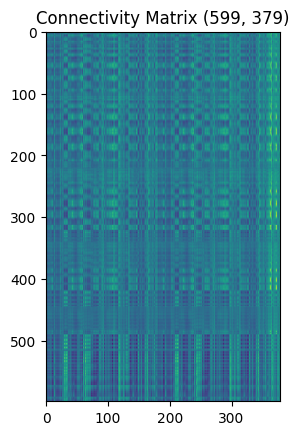

In [8]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr_avg)
ax.set_title('Connectivity Matrix {}'.format(corr_avg.shape))
plt.show()

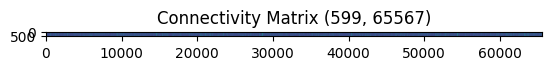

In [9]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr_concat)
ax.set_title('Connectivity Matrix {}'.format(corr_concat.shape))
plt.show()

### Spectral clustering

In [95]:
# Function to save niftis
def save_label_nii (labelimg,affine,header,out_nifti):
    img = nib.Nifti1Image(labelimg,affine=affine,header=header)
    nib.save(img,out_nifti)

# get seed data
afile = (data_path + 'seed-BASF_HCP-MMP_BigBrain1p6mm_59k.nii.gz')
atlas = nib.load(afile)
atlas_data = atlas.get_fdata()
    
# Output
max_k = 10
cluster_range = range(2,max_k+1)
cluster = list(cluster_range)
out_nii_list =[results_path + f'Func_HCPMMP_method-spectralcosine_k-'+ cluster +'_cluslabels.nii.gz' for cluster in[str(int) for int in cluster]]
labels = np.zeros((corr_concat.shape[0],len(cluster_range)))

# Run spectral clustering and save results to nifti
for i,k in enumerate(cluster_range):
    clustering = SpectralClustering(n_clusters=k, assign_labels="discretize",random_state=0,affinity='cosine').fit(corr_concat)
    labels[:,i] = clustering.labels_
    
    labelimg = np.zeros(atlas_data.shape)
    for j in range(0,len(atlas_data[atlas_data==16])):
        labelimg[indices[j][0],indices[j][1],indices[j][2]] = labels[j,i]+1
    
    print(f'i={i},k={k},saving {out_nii_list[i]}')
    save_label_nii(labelimg,atlas.affine,atlas.header,out_nii_list[i])



i=0,k=2,saving /srv/khan/users/sudesnac/00_Projects//BF_clustering/results/Func_concat/Func_HCPMMP_method-spectralcosine_k-2_cluslabels.nii.gz
i=1,k=3,saving /srv/khan/users/sudesnac/00_Projects//BF_clustering/results/Func_concat/Func_HCPMMP_method-spectralcosine_k-3_cluslabels.nii.gz
i=2,k=4,saving /srv/khan/users/sudesnac/00_Projects//BF_clustering/results/Func_concat/Func_HCPMMP_method-spectralcosine_k-4_cluslabels.nii.gz
i=3,k=5,saving /srv/khan/users/sudesnac/00_Projects//BF_clustering/results/Func_concat/Func_HCPMMP_method-spectralcosine_k-5_cluslabels.nii.gz
i=4,k=6,saving /srv/khan/users/sudesnac/00_Projects//BF_clustering/results/Func_concat/Func_HCPMMP_method-spectralcosine_k-6_cluslabels.nii.gz
i=5,k=7,saving /srv/khan/users/sudesnac/00_Projects//BF_clustering/results/Func_concat/Func_HCPMMP_method-spectralcosine_k-7_cluslabels.nii.gz
i=6,k=8,saving /srv/khan/users/sudesnac/00_Projects//BF_clustering/results/Func_concat/Func_HCPMMP_method-spectralcosine_k-8_cluslabels.nii.gz

In [96]:
# Save results to CSV file
df = pd.DataFrame(labels,columns=cluster_range)
df.to_csv(results_path + 'Func_HCPMMP_clusterlabels_seed-BASF_1p6mm.csv')

### Internal Index

In [14]:
spectral_model = {}
cluster_range = range(2,16)

# Concat data clustering
HCPcc_sil_scores = []
HCPcc_chi_scores = []
HCPcc_dbi_scores = []

for k in cluster_range:
    spectral_model[k] = SpectralClustering(n_clusters=k, assign_labels="discretize",random_state=0,affinity='cosine').fit(corr_concat)
    HCPcc_labels = spectral_model[k].labels_
    HCPcc_sil_scores.append(sklearn.metrics.silhouette_score(corr_concat, HCPcc_labels, metric='cosine'))
    HCPcc_chi_scores.append(sklearn.metrics.calinski_harabasz_score(corr_concat, HCPcc_labels))
    HCPcc_dbi_scores.append(davies_bouldin_score(corr_concat, HCPcc_labels))

# Average data clustering
HCPav_sil_scores = []
HCPav_chi_scores = []
HCPav_dbi_scores = []

for k in cluster_range:
    spectral_model[k] = SpectralClustering(n_clusters=k, assign_labels="discretize",random_state=0,affinity='cosine').fit(corr_avg)
    HCPav_labels = spectral_model[k].labels_
    HCPav_sil_scores.append(sklearn.metrics.silhouette_score(corr_avg, HCPav_labels, metric='cosine'))
    HCPav_chi_scores.append(sklearn.metrics.calinski_harabasz_score(corr_avg, HCPav_labels))
    HCPav_dbi_scores.append(davies_bouldin_score(corr_avg, HCPav_labels))

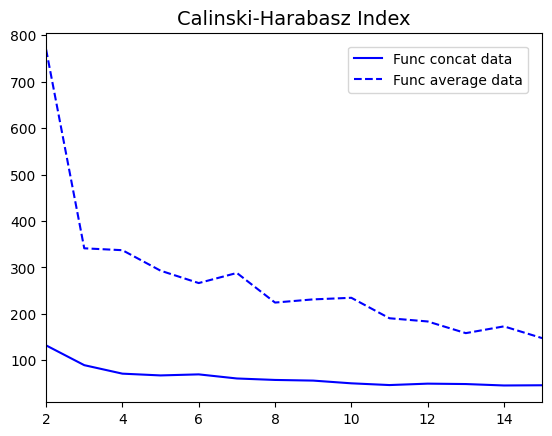

In [15]:
plt.gca().set_prop_cycle(color=['b','b'],linestyle=['-','--'])

plt.plot(cluster_range, HCPcc_chi_scores, label="Func concat data")
plt.plot(cluster_range, HCPav_chi_scores, label="Func average data")

plt.xlim(2,15)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=10)
plt.title('Calinski-Harabasz Index', fontsize=14)
plt.savefig(fig_path + f'Func_avg-con_Calinski-Harabasz_Index.png')
plt.show()

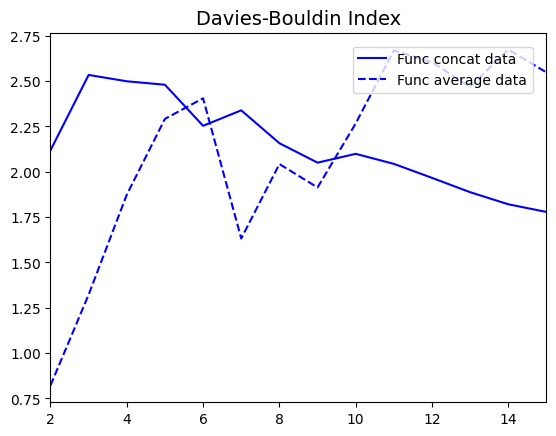

In [17]:
plt.gca().set_prop_cycle(color=['b','b'],linestyle=['-','--'])

plt.plot(cluster_range, HCPcc_dbi_scores, label="Func concat data")
plt.plot(cluster_range, HCPav_dbi_scores, label="Func average data")

plt.xlim(2,15)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=10)
plt.title('Davies-Bouldin Index', fontsize=14)
plt.savefig(fig_path + f'Func_avg-con_Davies-Bouldin_Index.png')
plt.show()

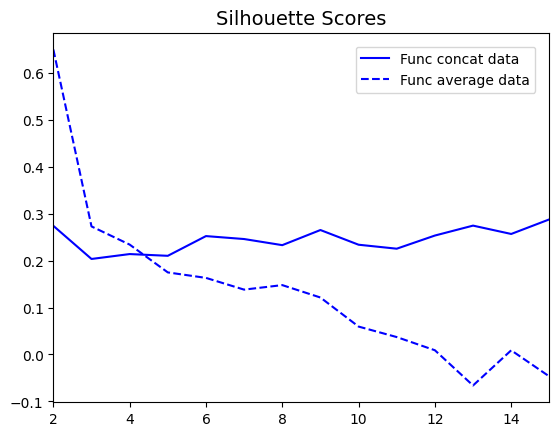

In [18]:
plt.gca().set_prop_cycle(color=['b','b'],linestyle=['-','--'])

plt.plot(cluster_range, HCPcc_sil_scores, label="Func concat data")
plt.plot(cluster_range, HCPav_sil_scores, label="Func average data")

plt.xlim(2,15)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=10)
plt.title('Silhouette Scores', fontsize=14)
plt.savefig(fig_path + f'Func_avg-con_Silhouette_Scores.png')
plt.show()

### Visualize cluster solution

In [102]:
from matplotlib.colors import ListedColormap
colors = (['red', 'green'], ['red', 'green','blue'],['red', 'green','blue','orange'],['red', 'green','blue','orange','purple'],
          ['red', 'green','blue','orange','purple', 'cyan'], ['red', 'green','blue','orange','purple', 'cyan','magenta']) # , 'cyan', 'magenta', 'brown'

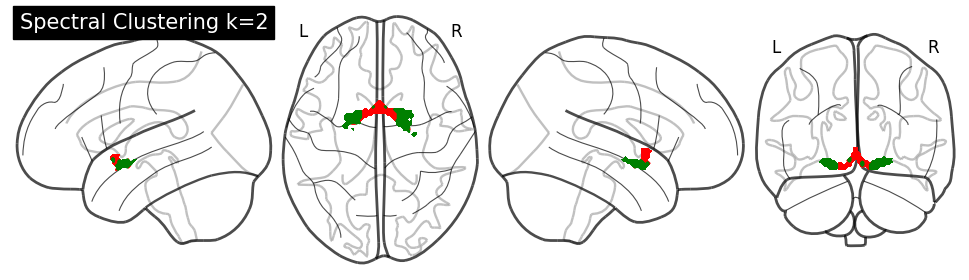

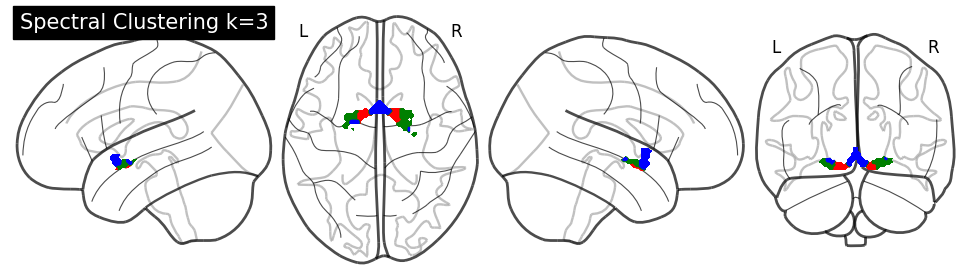

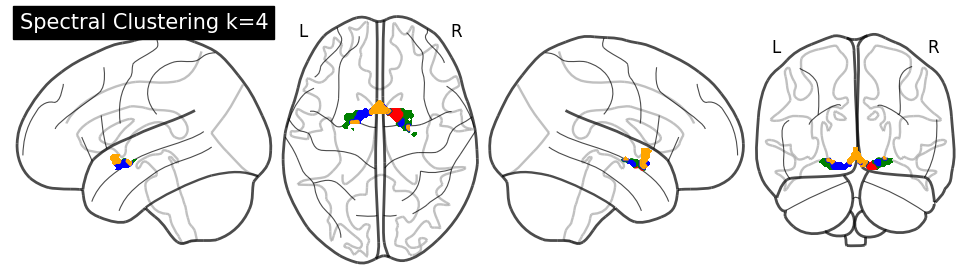

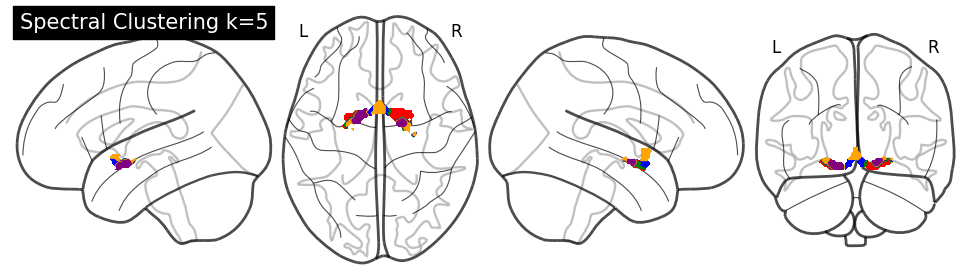

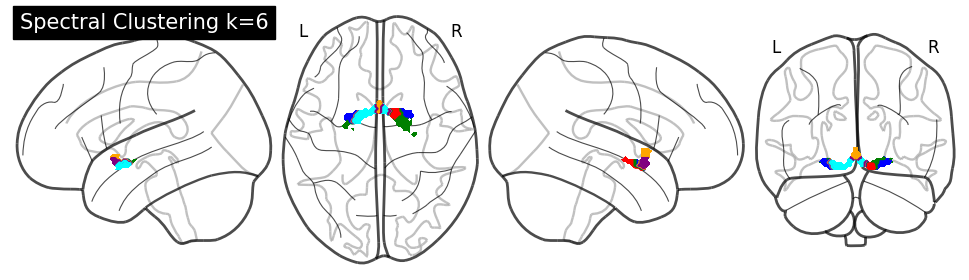

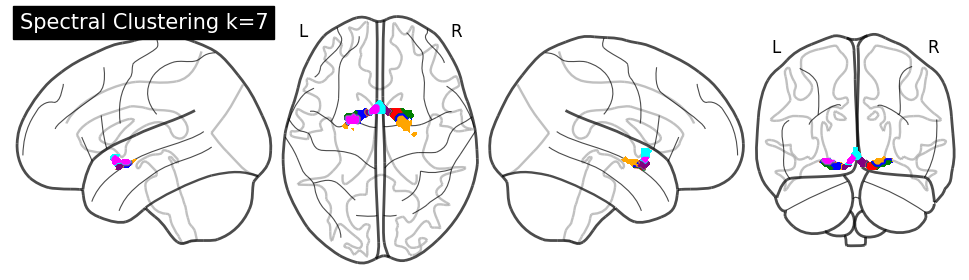

In [103]:
for k in range(6): # up to 6 cluster
    cluster = nib.load(results_path + f'Func_HCPMMP_method-spectralcosine_k-{k+2}_cluslabels.nii.gz')
    color = ListedColormap(colors[k])
    display = plotting.plot_glass_brain(None, display_mode='lzry', colorbar=True)
    display.add_contours(cluster, filled=True, cmap=color)
    display.title(f'Spectral Clustering k={k+2}')
    display.savefig(fig_path + f'Func_HCPMMP_method-spectralcosine_k-{k+2}_cluslabels.png', dpi=300)

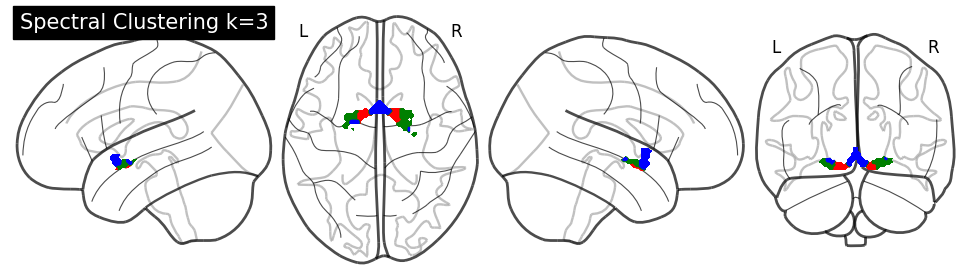

In [104]:
file = (results_path+'Func_HCPMMP_method-spectralcosine_k-3_cluslabels.nii.gz')
cluster = nib.load(file)
from matplotlib.colors import ListedColormap
colors = ListedColormap(['red', 'green', 'blue'])
display = plotting.plot_glass_brain(None, display_mode='lzry', colorbar=True)
display.add_contours(cluster, filled=True, cmap=colors)
display.title('Spectral Clustering k=3')
display.savefig(fig_path + 'Func_HCPMMP_method-spectralcosine_k-3_cluslabels.png')

In [105]:
fname = (results_path + 'Func_HCPMMP_method-spectralcosine_k-{0}_cluslabels.nii.gz')

In [106]:
G_idx = {}
G_values = {}
for k in range(2,7):
    G_nii = nib.load(fname.format(k)).get_fdata()
    G_idx[k] = np.argwhere(G_nii)
    G_values[k] = G_nii[G_idx[k][:,0], G_idx[k][:,1], G_idx[k][:,2]].flatten()

In [108]:
from matplotlib.colors import ListedColormap
colors = (['red', 'green'], ['red', 'green','blue'],['red', 'green','blue','orange'],['red', 'green','blue','orange','purple'],
          ['red', 'green','blue','orange','purple', 'cyan'], ['red', 'green','blue','orange','purple', 'cyan','magenta'])

/tmp/ipykernel_6235/2776890026.py:5: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=10


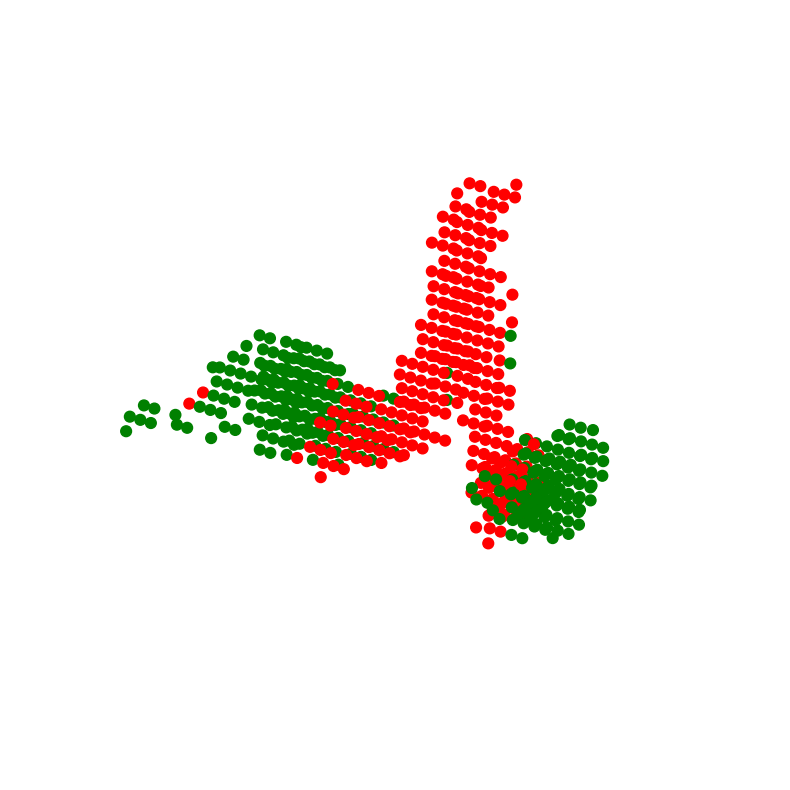

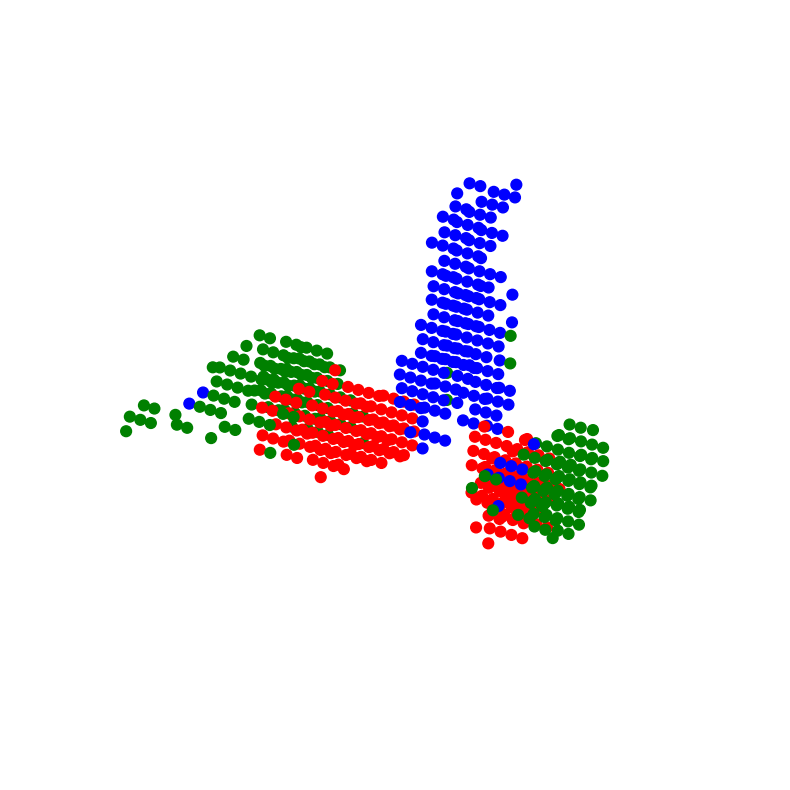

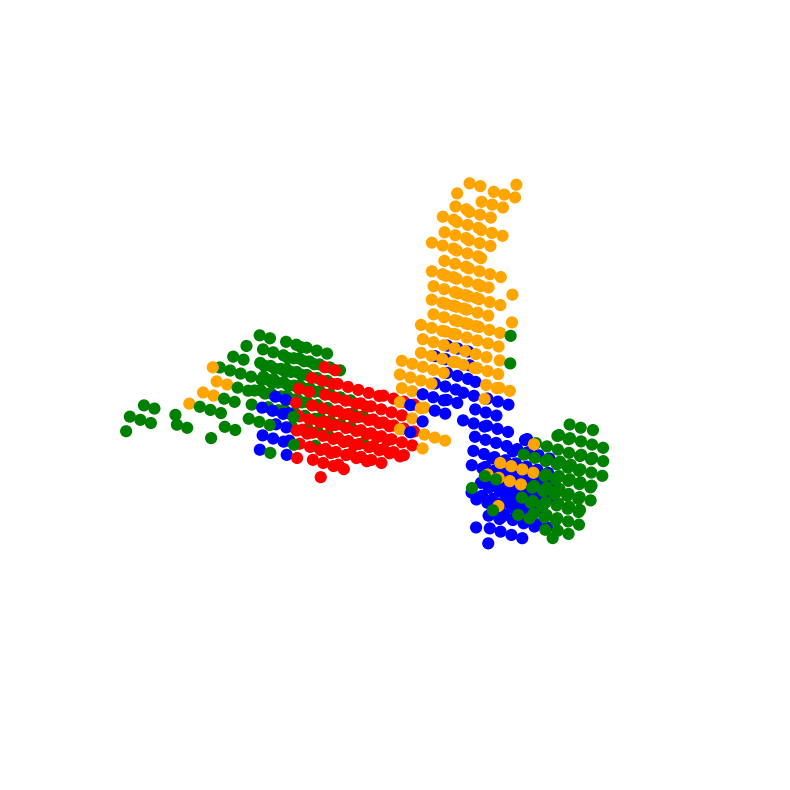

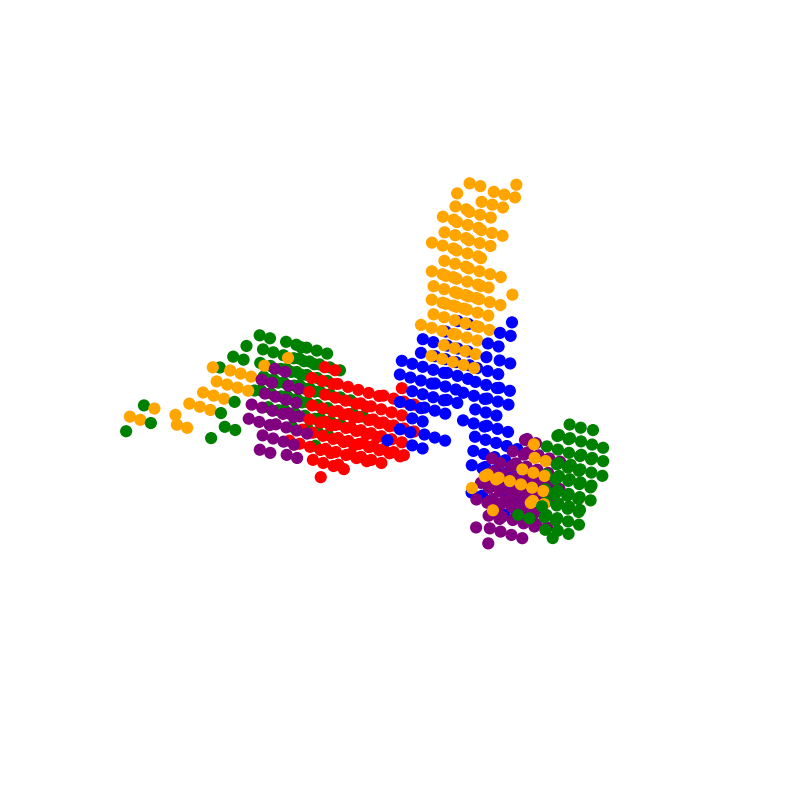

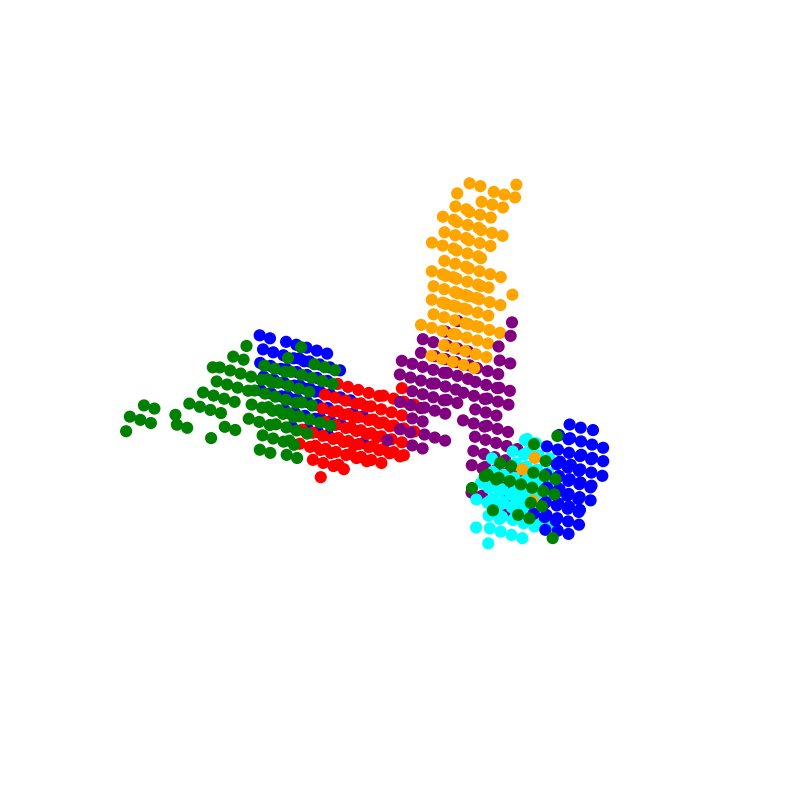

In [109]:
for k in range(2,7):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.dist=10
    ax.set_axis_off()
    
    color = ListedColormap(colors[k-2])
    ax.scatter(
        G_idx[k][:,0],
        G_idx[k][:,1],
        G_idx[k][:,2],
        s=60, alpha=1,
        cmap=color,
        c=G_values[k]
    )
    plt.savefig(fig_path+f'Func_HCPMMP_method-spectralcosine_k-{k}_scatterplot.png', dpi=300, bbox_inches='tight')
    plt.show()

### Cortical Projection

In [110]:
# Reading saved spetral clustering results file
clusterlabels_df = pd.read_csv(results_path + 'Func_HCPMMP_clusterlabels_seed-BASF_1p6mm.csv')
clusterlabels = clusterlabels_df.to_numpy()
k3_labels = clusterlabels[:,2]

In [111]:
cluster1_mat = corr_concat[k3_labels == 0]
cluster2_mat = corr_concat[k3_labels == 1]
cluster3_mat = corr_concat[k3_labels == 2]
cluster1_corr = np.reshape(cluster1_mat, (len(cluster1_mat[:,0]), 379, 173))
cluster2_corr = np.reshape(cluster2_mat, (len(cluster2_mat[:,0]), 379, 173)) 
cluster3_corr = np.reshape(cluster3_mat, (len(cluster3_mat[:,0]), 379, 173))
cluster1_corrFC = cluster1_corr[:,:-19,:]
cluster2_corrFC = cluster2_corr[:,:-19,:]
cluster3_corrFC = cluster3_corr[:,:-19,:]
clust1_avg = np.nanmean(cluster1_corrFC,axis=2)
clust2_avg = np.nanmean(cluster2_corrFC,axis=2)
clust3_avg = np.nanmean(cluster3_corrFC,axis=2)

In [112]:
pd.DataFrame(clust1_avg).to_csv(results_path + 'Func_HCPMMP_k3-cluster1_avg.csv', index=False)
pd.DataFrame(clust2_avg).to_csv(results_path + 'Func_HCPMMP_k3-cluster2_avg.csv', index=False)
pd.DataFrame(clust3_avg).to_csv(results_path + 'Func_HCPMMP_k3-cluster3_avg.csv', index=False)

In [113]:
clust1_ctx = np.nanmean(clust1_avg,axis=0).reshape([360,1])
clust2_ctx = np.nanmean(clust2_avg,axis=0).reshape([360,1])
clust3_ctx = np.nanmean(clust3_avg,axis=0).reshape([360,1])

In [114]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [115]:
k3clust1 = map_to_labels(clust1_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
k3clust2 = map_to_labels(clust2_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
k3clust3 = map_to_labels(clust3_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [116]:
# Plot on the surface and save as png file
plot_hemispheres(surf_lh, surf_rh, array_name=[k3clust1], label_text=['k-3 cluster1'],
    size=(800, 200),  cmap=['Reds'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Func_HCPMMP_k-3_cluster-1_Cortex.png')

'/srv/khan/users/sudesnac/00_Projects/BF_clustering/figures/Func_concat/Func_HCPMMP_k-3_cluster-1_Cortex.png'

In [117]:
plot_hemispheres(surf_lh, surf_rh, array_name=[k3clust2], label_text=['k-3 cluster2'],
    size=(800, 200),  cmap=['Greens'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Func_HCPMMP_k-3_cluster-2_Cortex.png')

'/srv/khan/users/sudesnac/00_Projects/BF_clustering/figures/Func_concat/Func_HCPMMP_k-3_cluster-2_Cortex.png'

In [118]:
plot_hemispheres(surf_lh, surf_rh, array_name=[k3clust3], label_text=['k-3 cluster3'],
    size=(800, 200),  cmap=['Blues'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Func_HCPMMP_k-3_cluster-3_Cortex.png')

'/srv/khan/users/sudesnac/00_Projects/BF_clustering/figures/Func_concat/Func_HCPMMP_k-3_cluster-3_Cortex.png'

In [119]:
# Save the cortical projection as gii files
k3_clusters = [k3clust1, k3clust2, k3clust3]

for c in range(0, len(k3_clusters)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(k3_clusters[c][:32492].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Func_HCPMMP_k-3_cluster-'+str(c+1)+'_L_fsa-10k.gii')

for c in range(0, len(k3_clusters)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(k3_clusters[c][32492:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Func_HCPMMP_k-3_cluster-'+str(c+1)+'_R_fsa-10k.gii')

### Visualize Cortical Projection

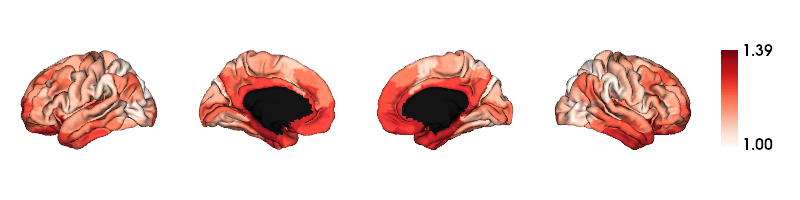

In [120]:
# For checking the saved cortical projection gii files
Sch_k3clust_L = images.load_gifti(results_path+'Func_HCPMMP_k-3_cluster-1_L_fsa-10k.gii')
Sch_k3clust_R = images.load_gifti(results_path+'Func_HCPMMP_k-3_cluster-1_R_fsa-10k.gii')
Sch_k3clust_L_data = Sch_k3clust_L.agg_data()
Sch_k3clust_R_data = Sch_k3clust_R.agg_data()
Sch_k3clust_data = np.concatenate((Sch_k3clust_L_data, Sch_k3clust_R_data))

surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[Sch_k3clust_data], size=(800, 200), cmap=['Reds'], color_bar=True, embed_nb=True)

In [199]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
clust1_scaled_data = min_max_scaler.fit_transform(k3clust1.reshape(-1, 1))
clust2_scaled_data = min_max_scaler.fit_transform(k3clust2.reshape(-1, 1))
clust3_scaled_data = min_max_scaler.fit_transform(k3clust3.reshape(-1, 1))

/tmp/ipykernel_6235/3912484727.py:12: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



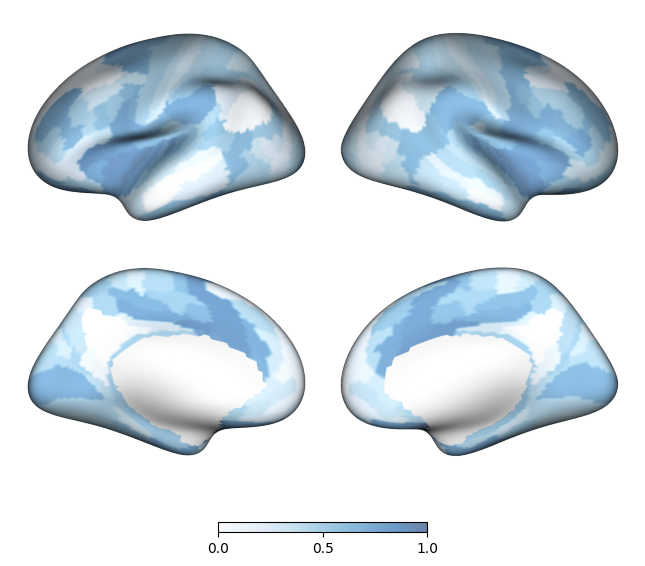

In [203]:
from surfplot import Plot
from neuromaps.datasets import fetch_fsaverage

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, brightness=.8)
#p.add_layer(clust1_scaled_data.reshape([20484]), cmap='Reds', cbar=True, color_range=[0,1], alpha=0.6)#, color_range=[0,1])
#p.add_layer(clust2_scaled_data.reshape([20484]), cmap='Greens', cbar=True, color_range=[0,1], alpha=0.6)
p.add_layer(clust2_scaled_data.reshape([20484]), cmap='Blues', cbar=True, color_range=[0,1], alpha=0.6)
fig = p.build()
fig.show()

### Cluster avg matrix for k up to 5

In [11]:
clusterlabels_df = pd.read_csv(results_path + 'Func_HCPMMP_clusterlabels_seed-BASF_1p6mm.csv')
clusterlabels = clusterlabels_df.to_numpy()
k_labels = {}
for k in range(1,6):
    k_labels[k] = clusterlabels[:,k]

In [36]:
k_mat = pd.DataFrame()
cluster_mat = {}
cluster_corr = {}
cluster_corrFC = {}
clust_avg = {}
for k in range(1,6):
    k_mat[k] = clust_avg
    for clus in range(5):
        cluster_mat[clus] = corr_concat[k_labels[k] == clus]
        cluster_corr[clus] = np.reshape(cluster_mat[clus], (len(cluster_mat[clus][:,0]), 379, 173))
        cluster_corrFC[clus] = cluster_corr[clus][:,:-19,:]
        clust_avg[clus] = np.nanmean(cluster_corrFC[clus],axis=2)

/tmp/ipykernel_6629/4130021384.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  k_mat[k] = clust_avg


In [42]:
k_mat[2][1].shape

(304, 360)

### Network associated with Cortical projection

In [121]:
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)

In [122]:
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()

In [123]:
clust1_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = clust1_avg[:,net_inds]
        net_mean.append(net_con_df.mean())

clust1_matrix.append(net_mean)

In [124]:
clust2_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = clust2_avg[:,net_inds]
        net_mean.append(net_con_df.mean())

clust2_matrix.append(net_mean)

In [125]:
clust3_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = clust3_avg[:,net_inds]
        net_mean.append(net_con_df.mean())

clust3_matrix.append(net_mean)

In [126]:
clust1_array = np.array(clust1_matrix)
clust2_array = np.array(clust2_matrix)
clust3_array = np.array(clust3_matrix)

In [127]:
cluster_network_df = pd.DataFrame({'networks':networks, 'clust1':clust1_array.reshape([7]), 'clust2':clust2_array.reshape([7]), 'clust3':clust3_array.reshape([7])})
pd.DataFrame(cluster_network_df).to_csv(results_path + 'Func_HCPMMP_k3-cluster_network.csv', index=False)

In [128]:
cluster_network_df = pd.read_csv(results_path + 'Func_HCPMMP_k3-cluster_network.csv')
cluster_network_df

networks    clust1    clust2    clust3
0             Visual  1.112483  1.142056  1.080884
1        Somatomotor  1.157429  1.215525  1.134924
2   Dorsal Attention  1.091599  1.197324  0.998851
3  Ventral Attention  1.123548  1.300244  0.999946
4            Default  1.216435  1.106560  1.247885
5     Frontoparietal  1.171531  1.188446  1.075770
6             Limbic  1.302602  1.243477  1.294780

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])


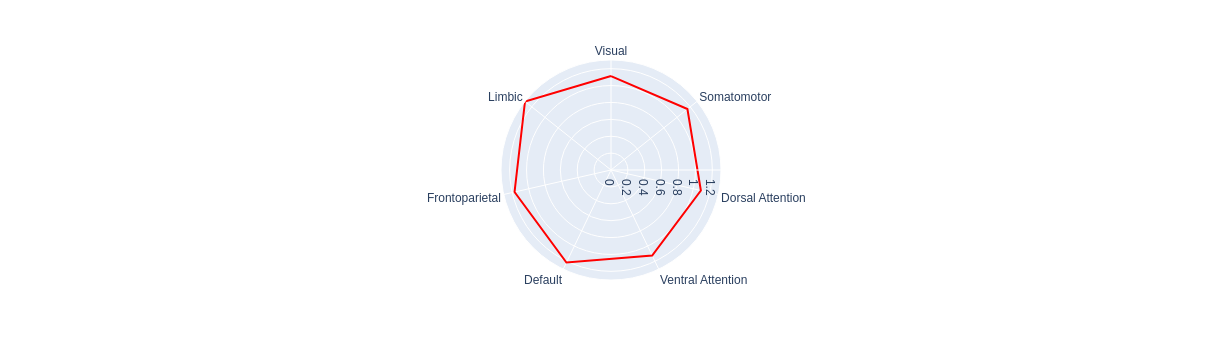

In [129]:
# Checking individual cluster network
fig = px.line_polar(cluster_network_df, r='clust1', theta='networks', color_discrete_sequence=['red'], line_close=True)
fig.show()

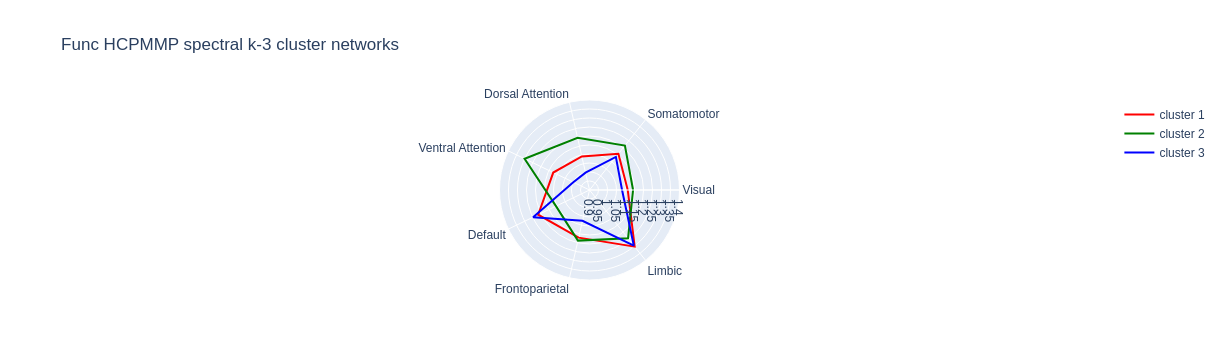

In [130]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=cluster_network_df['clust1'].values.tolist() + cluster_network_df['clust1'].values.tolist()[:1], theta=cluster_network_df['networks'].tolist() + cluster_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'red', name='cluster 1'))
fig.add_trace(go.Scatterpolar(r=cluster_network_df['clust2'].values.tolist() + cluster_network_df['clust2'].values.tolist()[:1], theta=cluster_network_df['networks'].tolist() + cluster_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'green', name='cluster 2'))
fig.add_trace(go.Scatterpolar(r=cluster_network_df['clust3'].values.tolist() + cluster_network_df['clust3'].values.tolist()[:1], theta=cluster_network_df['networks'].tolist() + cluster_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'blue', name='cluster 3'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0.9, 1.4])),title = 'k-3 clsuter networks', showlegend=True)

fig.update_layout(title = 'Func HCPMMP spectral k-3 cluster networks', showlegend=True)
fig.show()
fig.write_image(fig_path+'Func_HCPMMP_spectral_k-3_cluster_networks.png')

#### Network correspondence up to k = 5

In [43]:
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)

In [44]:
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()

In [45]:
k_mat

1                                                  2  \
0 NaN  [[1.1687671341530088, 1.0421752438212788, 1.01...   
1 NaN  [[1.3118251820094784, 1.1507702553532069, 1.15...   
2 NaN                                                 []   
3 NaN                                                 []   
4 NaN                                                 []   

                                                   3  \
0  [[1.3118251820094784, 1.1507702553532069, 1.15...   
1  [[1.3725920968291694, 1.1998588782081234, 1.23...   
2  [[1.1437174823643923, 1.0838978763039886, 1.04...   
3                                                 []   
4                                                 []   

                                                   4  \
0  [[1.3118251820094784, 1.1507702553532069, 1.15...   
1  [[1.3725920968291694, 1.1998588782081234, 1.23...   
2  [[1.1687671341530088, 1.0421752438212788, 1.01...   
3  [[1.1437174823643923, 1.0838978763039886, 1.04...   
4                                                 []   

                                                   5  
0  [[1.3118251820094784, 1.1507702553532069, 1.15...  
1  [[1.3725920968291694, 1.1998588782081234, 1.23...  
2  [[1.1687671341530088, 1.0421752438212788, 1.01...  
3  [[1.2027595461862046, 1.1430119162705743, 1.11...  
4  [[1.190055944343219, 1.0247283440302684, 1.010...

In [346]:
net_mean = {}
clust_net = {}
k_network = {}
for k in range(2,6):
    k_network[k] = pd.DataFrame()   
    for clus in range(k):
        for nets in networks:
            net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
            net_inds = list(net_df.index.values)
            net_con_df = k_mat[k][clus][:,net_inds]
            net_mean = net_con_df.mean()
            clust_net[nets] = net_mean
        k_network[k][clus] = pd.Series(clust_net)

In [345]:
k_network[3]

0         1         2
Visual             1.112483  1.142056  1.080884
Somatomotor        1.157429  1.215525  1.134924
Dorsal Attention   1.091599  1.197324  0.998851
Ventral Attention  1.123548  1.300244  0.999946
Default            1.216435  1.106560  1.247885
Frontoparietal     1.171531  1.188446  1.075770
Limbic             1.302602  1.243477  1.294780

In [349]:
for k in range(2,6):
    pd.DataFrame(k_network[k]).to_csv(results_path + f'Func_HCPMMP_k-'+str(k)+'_cluster_networks.csv')

In [350]:
networks = {}
for k in range(2,6):
    networks[k] = pd.read_csv(results_path + f'Func_HCPMMP_k-'+str(k)+'_cluster_networks.csv')

In [353]:
networks[3]

networks         1         2         3
0             Visual  1.112483  1.142056  1.080884
1        Somatomotor  1.157429  1.215525  1.134924
2   Dorsal Attention  1.091599  1.197324  0.998851
3  Ventral Attention  1.123548  1.300244  0.999946
4            Default  1.216435  1.106560  1.247885
5     Frontoparietal  1.171531  1.188446  1.075770
6             Limbic  1.302602  1.243477  1.294780

In [356]:
networks_melt = {}
for k in range(2,6):
    networks_melt[k] = pd.melt(networks[k], id_vars=['networks'], var_name='cluster', value_name='net_mean')

In [358]:
networks_melt[3]

networks cluster  net_mean
0              Visual       1  1.112483
1         Somatomotor       1  1.157429
2    Dorsal Attention       1  1.091599
3   Ventral Attention       1  1.123548
4             Default       1  1.216435
5      Frontoparietal       1  1.171531
6              Limbic       1  1.302602
7              Visual       2  1.142056
8         Somatomotor       2  1.215525
9    Dorsal Attention       2  1.197324
10  Ventral Attention       2  1.300244
11            Default       2  1.106560
12     Frontoparietal       2  1.188446
13             Limbic       2  1.243477
14             Visual       3  1.080884
15        Somatomotor       3  1.134924
16   Dorsal Attention       3  0.998851
17  Ventral Attention       3  0.999946
18            Default       3  1.247885
19     Frontoparietal       3  1.075770
20             Limbic       3  1.294780

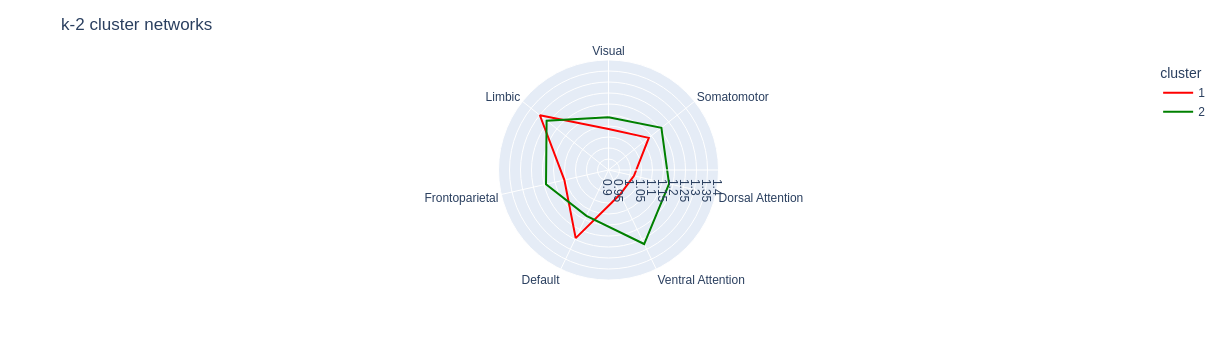

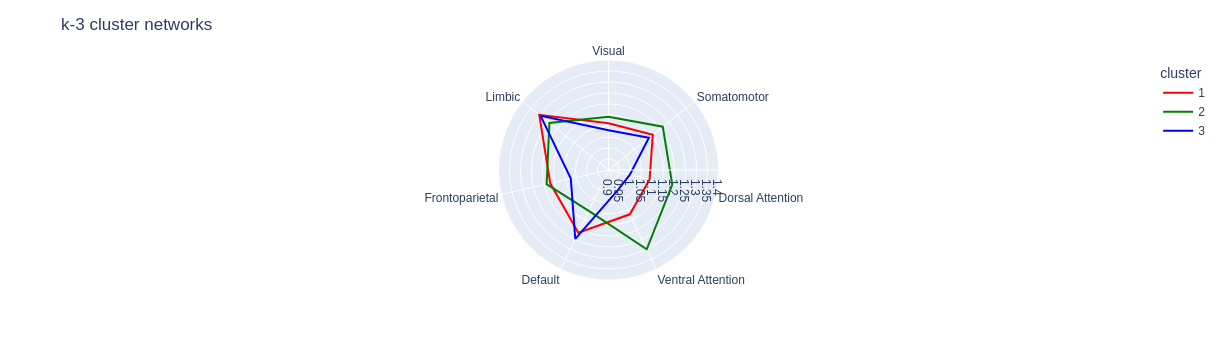

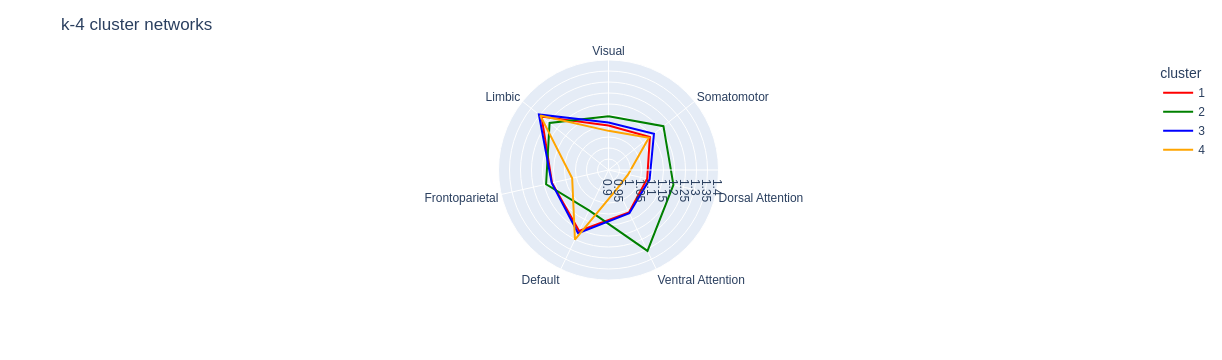

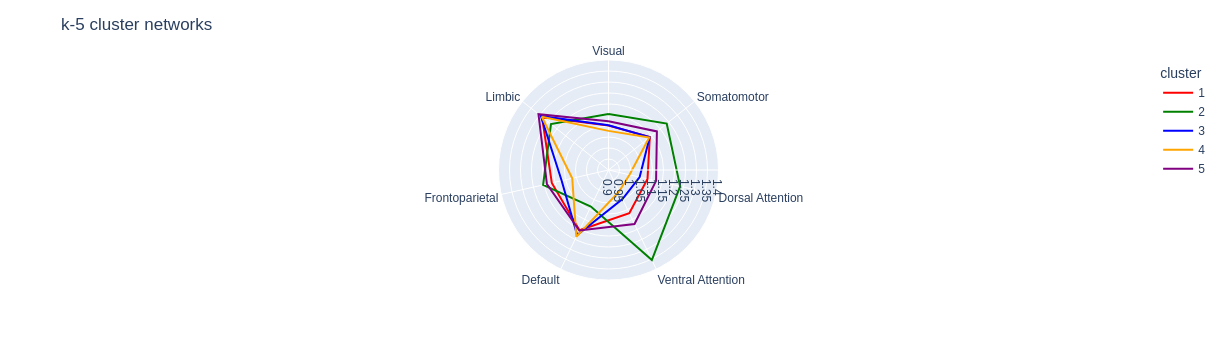

In [365]:
for k in range(2,6):
    fig = px.line_polar(networks_melt[k], r='net_mean', theta='networks', 
                        color = "cluster", color_discrete_sequence=['red','green','blue', 'orange', 'purple'], line_close=True)
    fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0.9, 1.4])),title = f'k-'+str(k)+' cluster networks', showlegend=True)
    fig.show()
    fig.write_image(fig_path+f'Func_HCPMMP_spectral_k-'+str(k)+'_cluster_networks.png', scale=1.5)

### Comparision with BF histological subdivision

In [131]:
# load labeled BF atlas
subBF_nib = nib.load(data_path+'BF_masked_fullB_1p6mm.dseg.nii.gz')
subBF_vol = subBF_nib.get_fdata()

In [151]:
subBF_vol.shape

(113, 136, 113)

In [132]:
bf_idx = np.argwhere(subBF_vol)
bf_values = subBF_vol[bf_idx[:,0], bf_idx[:,1], bf_idx[:,2]].flatten()

/tmp/ipykernel_6235/3632316781.py:6: MatplotlibDeprecationWarning:

The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.



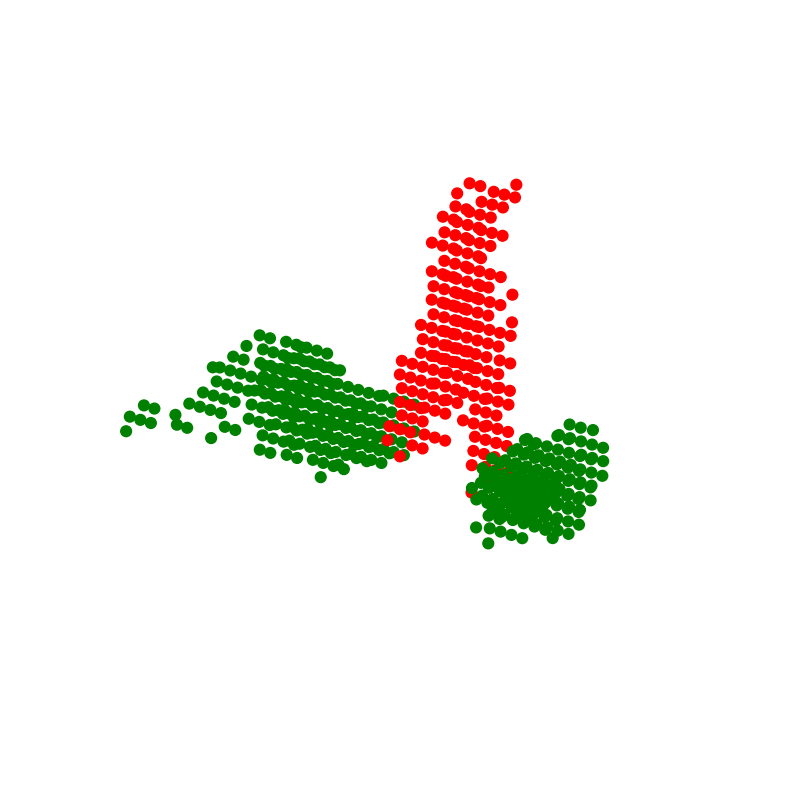

In [133]:
from matplotlib.colors import ListedColormap
colors = ListedColormap(['red', 'green'])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.dist=10
ax.set_axis_off()
    
ax.scatter(
    bf_idx[:,0],
    bf_idx[:,1],
    bf_idx[:,2],
    s=60, alpha=1,
    cmap=colors,
    c=bf_values
)

plt.savefig(fig_path+f'BF-atlas_color-ref.png', dpi=300, bbox_inches='tight')
plt.show()

In [152]:
ch123 = np.zeros(subBF_vol.shape)
ch123_data = np.where(subBF_vol==1, 1, ch123)

In [154]:
ch4 = np.zeros(subBF_vol.shape)
ch4_data = np.where(subBF_vol==2, 1, ch4)

In [156]:
file = nib.load(results_path+'Func_HCPMMP_method-spectralcosine_k-3_cluslabels.nii.gz')
cluster = file.get_fdata()

In [161]:
clust1 = np.zeros(cluster.shape)
clust1_data = np.where(cluster==1, 1, clust1)

In [164]:
clust2 = np.zeros(cluster.shape)
clust2_data = np.where(cluster==2, 1, clust2)

In [165]:
clust3 = np.zeros(cluster.shape)
clust3_data = np.where(cluster==3, 1, clust3)

In [174]:
def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [177]:
dice(ch123_data, clust2_data)

0.0196078431372549

In [178]:
ch123_clust1 = dice(ch123_data, clust1_data)
ch123_clust2 = dice(ch123_data, clust2_data)
ch123_clust3 = dice(ch123_data, clust3_data)

In [179]:
ch123_ds = [ch123_clust1, ch123_clust2, ch123_clust3]

In [180]:
ch123_ds

[0.11471321695760599, 0.0196078431372549, 0.8978494623655914]

In [181]:
ch4_clust1 = dice(ch4_data, clust1_data)
ch4_clust2 = dice(ch4_data, clust2_data)
ch4_clust3 = dice(ch4_data, clust3_data)

In [182]:
ch4_ds = [ch4_clust1, ch4_clust2, ch4_clust3]

In [183]:
ch4_ds

[0.6013071895424836, 0.678513731825525, 0.03773584905660377]

In [184]:
labels = ['cluster-1', 'cluster-2','cluster-3']

<BarContainer object of 3 artists>

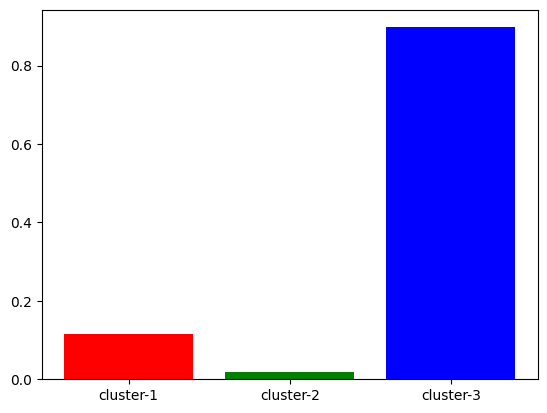

In [185]:
plt.bar(labels, ch123_ds, color=['red', 'green', 'blue'])

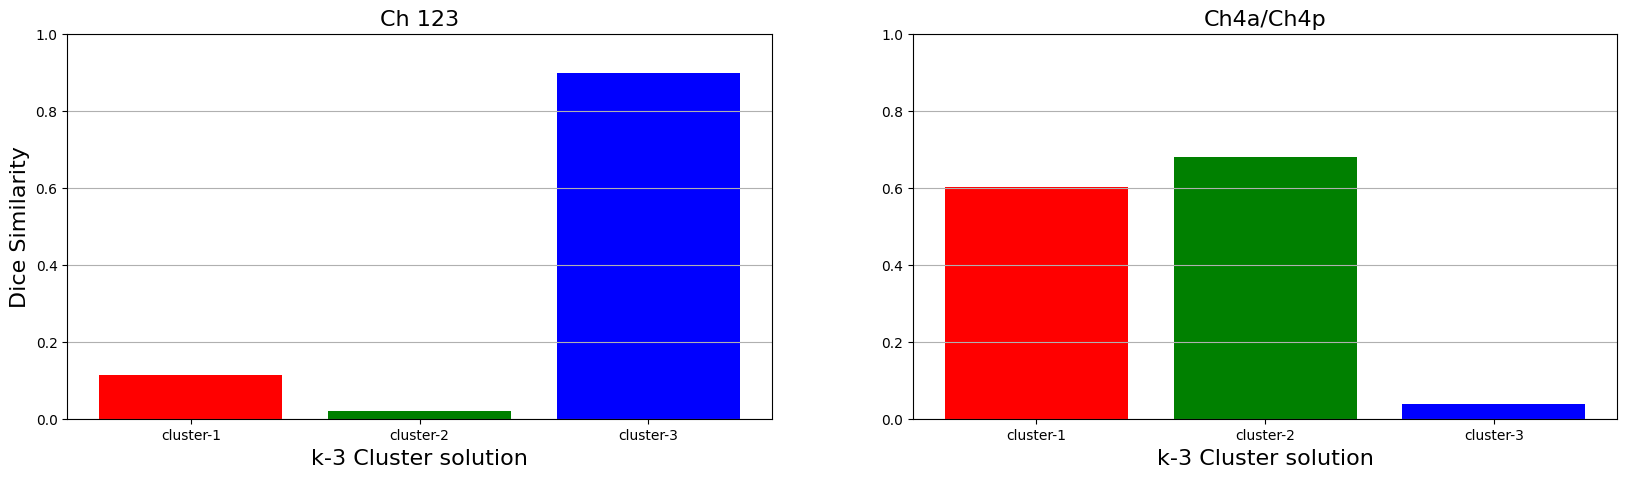

In [189]:
# boxplot

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# rectangular box plot
bplot1 = ax1.bar(labels, ch123_ds,color=['red', 'green', 'blue'])  # will be used to label x-ticks
ax1.set_ylim([0, 1.0])
ax1.set_title('Ch 123', fontsize=16)

bplot2 = ax2.bar(labels, ch4_ds,color=['red', 'green', 'blue'])  # will be used to label x-ticks
ax2.set_ylim([0, 1.0])
ax2.set_title('Ch4a/Ch4p', fontsize=16)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('k-3 Cluster solution', fontsize=16)

for ax in [ax1]:
    ax.set_ylabel('Dice Similarity', fontsize=16)

plt.savefig(fig_path+f'Func_HCPMMP_k-3clusterxatlas_barplot.png', dpi=300, bbox_inches='tight')
plt.show()